# Graph SLAM Problem

$\min J(x_i) = x_0^T\Omega_0 x_0 + \sum_t e_t R_t^{-1} e_t  + \sum_t \sum_i \tilde{z}^i_t  Q_t^{-1} \tilde{z}^i_t \$

$ e_t \equiv x_t - g(u_t, x_{t-1})$ prediction error at time t

$\tilde{z}^i_t \equiv z^i_t - h(x_t, m^i_t)$ measurement error

$\dot{p_x} = v_x$

$\dot{p_y} = v_y$

$x_t = \begin{bmatrix} p_x \\ p_y \end{bmatrix}$
$u_t = \begin{bmatrix} v_x \\ v_y \end{bmatrix}$

$x_t = x_{t-1} + \Delta_t u_t $

$g(u_t, x_t{-1}) = x_{t-1}  + \Delta_t u_t$

Landmarks are points. And our measurement is relative position.

In [3]:
%load_ext autoreload
%autoreload 2 

import matplotlib.pyplot as plt
import numpy as np
import casadi as ca
import slam2d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[[[3.35478331e-19]]

 [[9.18386442e-26]]

 [[1.76507628e-29]]

 [[2.12932578e-22]]

 [[6.89136177e-01]]]


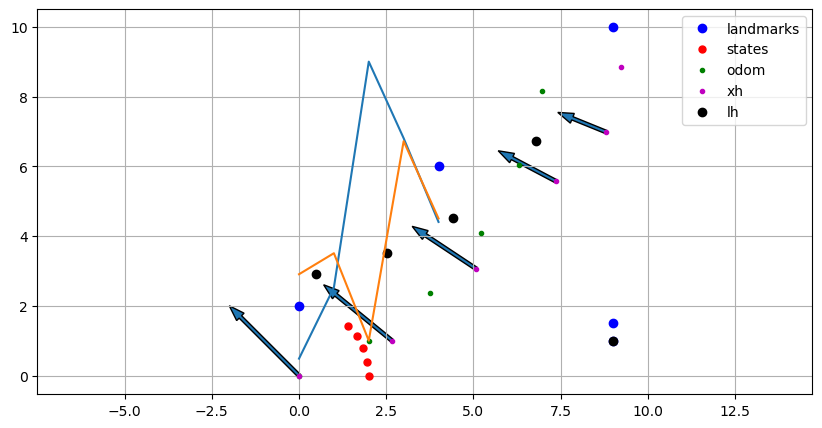

In [4]:
noise={
    'odom_std': 0,
    'bearing_std': 0,
    'range_std': 0,
    'odom_bx_bias': 0,
    'odom_by_bias': 0.5
}

plt.figure(figsize=(10, 5))

sim = slam2d.simulate(noise=noise, plot=True, tf=10);

print(sim['hist']['J'])

# plt.figure()
# plt.plot(sim['hist']['t'], sim['hist']['J'][:,0,0])

In [11]:
sim['hist']

{'t': array([0, 2, 4, 6, 8]),
 'x': array([[2.        , 0.        ],
        [1.96013316, 0.39733866],
        [1.84212199, 0.77883668],
        [1.65067123, 1.12928495],
        [1.39341342, 1.43471218]]),
 'u': array([[1.        , 0.        ],
        [0.98006658, 0.19866933],
        [0.92106099, 0.38941834],
        [0.82533561, 0.56464247],
        [0.69670671, 0.71735609]]),
 'odom': array([[2.        , 1.        , 0.        ],
        [1.76146382, 1.37740524, 1.        ],
        [1.45270365, 1.69989768, 2.        ],
        [1.08602876, 1.95462056, 3.        ],
        [0.67605733, 2.13141889, 4.        ]]),
 'z': array([[2.82842712, 2.35619449, 0.        ],
        [2.53192523, 2.45619449, 1.        ],
        [2.21012517, 2.55619449, 2.        ],
        [1.86624227, 2.65619449, 3.        ],
        [1.5037125 , 2.75619449, 4.        ]]),
 'xh': array([[  0.        ,   0.        ],
        [  4.        ,   1.        ],
        [  6.78789787,   4.71972267],
        [  9.255852

In [4]:
sim['optim'].keys()

dict_keys(['f', 'g', 'lam_g', 'lam_p', 'lam_x', 'x'])

In [ ]:
# data from sim
odom = sim['hist']['odom']
l = sim['landmarks']
z = sim['hist']['z']
hist = sim['hist']

# initialize x guess from odom
x0 = sim['hist']['x']
# print(x0[:,0].shape)
x1 = x0[:,0]
x2 = x0[:,1]
l1 = l[:,0]
l2 = l[:,1]
x0_new = np.hstack([x1, x2, l1, l2])
n_x = len(hist['x'])
x0_all = np.zeros([n_x+1,2])
x0_all[1: :] = x0

# compute data associations
assoc = [ slam2d.data_association(x0_all[int(xi), :], np.array([rng, bearing]), l) for rng, bearing, xi in z ]
print(assoc)

# build cost
f_J, J = slam2d.build_cost(odom, z, assoc, x0.shape[0], l.shape[0])

# compute cost , this is where we will send it to casadi nonlinear optim
f_J(x0, l)

# Symbols/expressions
nlp = {}                 # NLP declaration
nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
nlp['f'] = J           # objective
nlp['g'] = 0             # constraints

# Create solver instance
F = ca.nlpsol('F','ipopt',nlp);

# Solve the problem using a guess
# This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
optim = F(x0=x0_new)

# Re-associate landmark/measurements given new xstar positions
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
x_allstar = np.zeros([n_x+1,2])
x_allstar[1: :] = xstar

zstar = []
for i in range(n_x):
    x = x_allstar[i,:]
    
    # measure landmarks
    z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

    for z in z_list:
        zstar.append(np.hstack([z, i]))

zstar = np.array(zstar)


new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]
print(type(new_assoc))

# # Loop through optimization and reassociation until the new association matches the old association.
# while new_assoc != assoc:
#     # build cost
#     f_J, J = slam2d.build_cost(odom, z, new_assoc, xstar.shape[0], lstar.shape[0])

#     # compute cost , this is where we will send it to casadi nonlinear optim
#     f_J(xstar, l)

#     # Symbols/expressions
#     nlp = {}                 # NLP declaration
#     nlp['x']= ca.vertcat(f_J.sx_in()[0][:,0], f_J.sx_in()[0][:,1], f_J.sx_in()[1][:,0], f_J.sx_in()[1][:,1]) # decision vars
#     nlp['f'] = J           # objective
#     nlp['g'] = 0             # constraints

#     # Create solver instance
#     F = ca.nlpsol('F','ipopt',nlp);

#     # Solve the problem using a guess
#     # This uses original landmark/measure association (associates which landmark we think the measurement is measuring)
#     xstar1 = xstar[:,0]
#     xstar2 = xstar[:,1]
#     lstar1 = l[:,0]
#     lstar2 = l[:,1]
#     xstar_new = np.hstack([xstar1, xstar2, lstar1, lstar2])
#     optim = F(x0=xstar_new)

#     # Re-associate landmark/measurements given new xstar positions
#     hist = sim['hist']
#     n_x = len(hist['x'])
#     n_l = len(sim['landmarks'])
#     xstar = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
#     lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
#     x_allstar = np.zeros([n_x+1,2])
#     x_allstar[1: :] = xstar

#     zstar = []
#     for i in range(n_x):
#         x = x_allstar[i,:]

#         # measure landmarks
#         z_list = slam2d.measure_landmarks(x, lstar, noise=noise)

#         for z in z_list:
#             zstar.append(np.hstack([z, i]))

#     zstar = np.array(zstar)


#     new_assoc = [ slam2d.data_association(x_allstar[int(xi), :], np.array([rng, bearing]), lstar) for rng, bearing, xi in zstar ]


0.198451


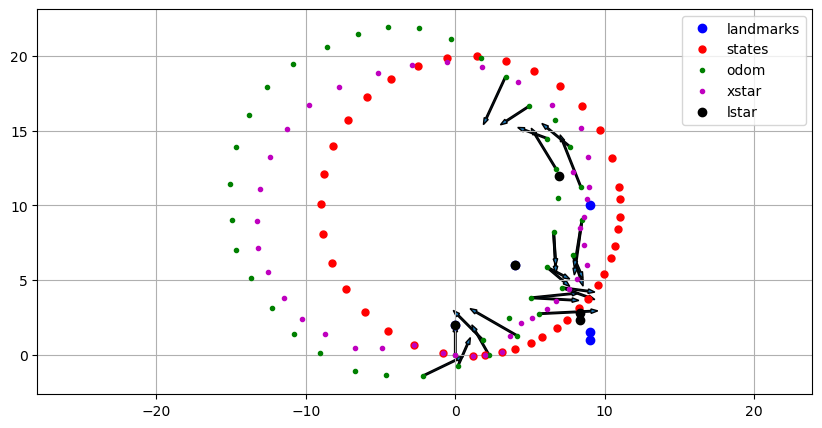

In [4]:
hist = sim['hist']
n_x = len(hist['x'])
n_l = len(sim['landmarks'])
xstar = np.zeros([n_x+1,2])
xstar[1: :] = np.reshape(optim['x'][0:2*n_x], [n_x,2], order='F')
lstar = np.reshape(optim['x'][2*n_x:None], [n_l,2], order='F')
print(optim['f'])
plt.figure(figsize=(10, 5))
slam2d.plot_me(sim)
for rng, bearing, xi in hist['z']:
    xi = int(xi)
    x = xstar[xi, :]
    # plt.arrow(x[0], x[1], rng*np.cos(bearing) , rng*np.sin(bearing), width=0.1,
    #               length_includes_head=True)
plt.plot(xstar[:, 0], xstar[:, 1], 'm.', linewidth=3, label='xstar')
plt.plot(lstar[:, 0], lstar[:, 1], 'ko', label='lstar')
plt.legend()

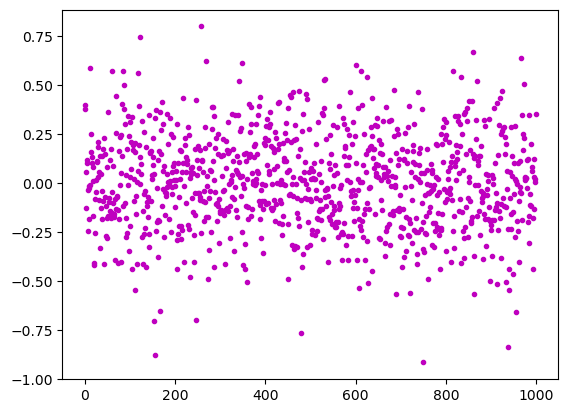

In [5]:
for lcv in range(1000):
    x = np.random.uniform(-1, 1)
    x_norm = (np.random.randn() + 0) / (4) * 1
    x2 = np.random.randn()
    # plt.plot(lcv,x,'r.')
    # plt.plot(lcv,x2,'k.')
    plt.plot(lcv,x_norm,'m.')

In [6]:
ca.__version__

'3.5.5'